In [1]:
import pandas as pd
from pytorch_geometric_dataset import LOL_Dataset
from torch_geometric.transforms import NormalizeFeatures
from train_utils import ConcatNodeCentralities
from train_utils import CustomRandomNodeSplitMasker, CustomRandomNodeUnderSampler, ConcatNodeCentralities
import torch
from torch_geometric.transforms import NormalizeFeatures, Compose, ToDevice
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import networkit as nk


In [2]:
RAW_FILENAME = "lol_C_M_GM_processed_normalized_D04-19-2024T12_33_31.csv"

lol_df = pd.read_csv(RAW_FILENAME)

In [3]:
lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8187 entries, 0 to 8186
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   username                   8187 non-null   object 
 1   tagline                    8186 non-null   object 
 2   tier                       8187 non-null   int64  
 3   level                      8187 non-null   int64  
 4   total_wins                 8187 non-null   int64  
 5   total_losses               8187 non-null   int64  
 6   past_n_wins                8187 non-null   int64  
 7   past_n_losses              8187 non-null   int64  
 8   damage_dealt_to_champions  8187 non-null   float64
 9   damage_taken               8187 non-null   float64
 10  control_wards_placed       8187 non-null   float64
 11  wards_placed               8187 non-null   float64
 12  wards_kills                8187 non-null   float64
 13  kills                      8187 non-null   float

In [4]:
lol_df.head()

,username,tagline,tier,level,total_wins,total_losses,past_n_wins,past_n_losses,damage_dealt_to_champions,damage_taken,...,deaths,assists,kill_participation,creep_score,players_played_with,adc,jungle,mid,support,top
0,yuu13,sus,0,79,146,63,14,6,22431.25,22894.65,...,5.10,7.75,0.616949,164.70,"['Yozu#Lux', 'DARKWINGS#NA3', 'pisslowsupport6...",0,1,0,0,0
1,zz1,NA1,0,139,241,157,12,8,20862.05,22507.35,...,5.20,5.70,0.561837,153.10,"['bradleyyy#0002', 'lyteskin#lyte', 'Neøø#1012...",0,0,1,0,0
2,buenos dias,cat,0,665,318,252,9,11,19728.10,30792.00,...,5.55,7.35,0.586639,171.35,"['Tenacity#NA1', 'Main Sup#XDD', 'zz1#NA1', 'P...",0,1,0,0,0
3,FLY Quad,123,0,53,167,88,10,10,25843.90,21683.30,...,4.30,9.40,0.566972,187.60,"['Cody Sun#COS', 'FLY Busio#000', 'Scibbles#Ma...",0,0,1,0,0
4,Kenvi,NA1,0,305,178,119,12,8,20952.75,30173.00,...,3.70,7.20,0.676647,167.25,"['Lancelot Link#NA1', 'c2 meteos#NA1', 'next t...",0,1,0,0,0


In [5]:
lol_df["tier"].value_counts()

tier
2    7187
1     700
0     300
Name: count, dtype: int64

In [6]:
duplicates = lol_df.duplicated(subset=['username'], keep=False)
duplicate_rows = lol_df[duplicates].sort_values(by="username")
duplicate_rows.head(10)

,username,tagline,tier,level,total_wins,total_losses,past_n_wins,past_n_losses,damage_dealt_to_champions,damage_taken,...,deaths,assists,kill_participation,creep_score,players_played_with,adc,jungle,mid,support,top
3265,888,NA2,2,511,38,34,11,9,19012.95,23117.55,...,5.50,5.45,0.472795,189.40,"['xSantaBearx#NA1', 'The Krow#NA1', 'best lol ...",0,0,1,0,0
4393,888,1995,2,217,244,237,10,10,19249.25,18381.35,...,4.20,4.95,0.351085,191.75,"['UW Scrimm#1v9', 'Cute Timmo#NA1', 'Black Lot...",0,0,0,0,1
3300,ADC,ZYH,1,53,83,47,11,9,19322.15,17944.65,...,5.50,7.05,0.488722,200.60,"['Love Ego#1tap', 'Crucile#NA1', 'ttv ssyeu#ss...",1,0,0,0,0
7382,ADC,MUNCH,2,670,340,353,8,12,20643.00,20190.95,...,6.85,5.20,0.515275,174.70,"['Kakoos#NA1', 'Derek#VNM1', 'kevinnguyensocal...",1,0,0,0,0
4291,Adam,GB2,2,50,123,87,9,11,16547.05,16492.40,...,4.95,5.80,0.443763,182.25,"['FR1DGE#USA', 'Bouj#NA1', 'Bungo BALLS#BOOM',...",1,0,0,0,0
6131,Adam,NA02,2,78,31,19,10,9,9998.15,21992.35,...,5.45,11.25,0.494792,31.40,"['SIEGE MACHINE#NA1', 'FufuSauceGraine#Afrik',...",0,0,0,1,0
1554,Asleep,THSMS,2,63,129,101,16,4,8977.10,12579.95,...,3.20,12.30,0.647321,33.40,"['Wizard101 BF#Zach', 'Mori#88888', 'Nimb#CAT'...",0,0,0,1,0
4251,Asleep,Pengu,2,754,38,30,11,9,12483.30,16710.30,...,4.40,12.50,0.649378,30.90,"['Akadian Pasha#NA1', '邪悪な#Dev', 'repiv#0000',...",0,0,0,1,0
1176,Asuna,5103,0,74,304,250,14,6,12597.00,16788.90,...,3.65,13.75,0.671518,32.30,"['12 Pouces Mou#NA1', 'lyteskin#lyte', 'Sharpe...",0,0,0,1,0
8034,Asuna,1Yuki,1,707,130,106,13,7,14609.45,21501.35,...,3.45,4.70,0.385417,156.40,"['NoPause#클로버', 'Super Big Ego#NA1', 'Celerity...",0,0,0,0,1


In [7]:
ROOT_DIR="PTG_data"
OUTPUT_DIR = "./experiments"
NUM_EPOCHS = 100
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
RANDOM_STATE = 42
BATCH_SIZE = 10
HIDDEN_CHANNELS = 32
torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nodeUnderSample = CustomRandomNodeUnderSampler(RANDOM_STATE, allowSelfLoops=False)
nodeSPlitMasker = CustomRandomNodeSplitMasker(
    test_size=TEST_SIZE,
    validation_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE
)
concatNodeCentralitiesTransformer = ConcatNodeCentralities()
train_transformer = Compose(
    [
        # NormalizeFeatures(),
        ToDevice(DEVICE),
        # nodeSPlitMasker
    ]
)
train_val_test_pre_transforms = Compose(
    [
        nodeUnderSample,
        # concatNodeCentralitiesTransformer
    ]
)

In [8]:
lol_graph = LOL_Dataset(
    root=ROOT_DIR,
    transform=train_transformer,
    pre_transform=train_val_test_pre_transforms
)

/usr/local/lib/python3.12/site-packages/torch_geometric/data/dataset.py:242: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [9]:
print()
print(f'lol_graph: {lol_graph}:')
print('======================')
print(f'Number of graphs: {len(lol_graph)}')
print(f'Number of features: {lol_graph.num_features}')
print(f'Number of classes: {lol_graph.num_classes}')
graph1 = lol_graph[0]  # Get the first graph object.

print()
print(graph1)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {graph1.num_nodes}')
print(f'Number of edges: {graph1.num_edges}')
print(f'Average node degree: {graph1.num_edges / graph1.num_nodes:.2f}')
print(f'Has isolated nodes: {graph1.has_isolated_nodes()}')
print(f'Has self-loops: {graph1.has_self_loops()}')
print(f'Is undirected: {graph1.is_undirected()}')
print(graph1.x[0])


lol_graph: LOL_Dataset():
Number of graphs: 1
Number of features: 20
Number of classes: 3

Data(x=[894, 20], edge_index=[2, 60676], y=[894])
Number of nodes: 894
Number of edges: 60676
Average node degree: 67.87
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([7.9000e+01, 1.4600e+02, 6.3000e+01, 1.4000e+01, 6.0000e+00, 2.2431e+04,
        2.2895e+04, 1.1500e+00, 7.7000e+00, 2.3500e+00, 1.0450e+01, 5.1000e+00,
        7.7500e+00, 6.1695e-01, 1.6470e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0', dtype=torch.float64)


In [10]:
G2 = to_networkx(graph1)

In [11]:
num_nodes = G2.number_of_nodes()
num_edges = G2.number_of_edges()
density = nx.density(G2)
is_directed = nx.is_directed(G2)

average_degree = sum(dict(G2.degree()).values()) / num_nodes
has_isolated_nodes = nx.isolates(G2) != []
has_self_loops = any([True for u, v in G2.edges() if u == v])

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average node degree:", average_degree)
print("Has isolated nodes:", has_isolated_nodes)
print("Num isolated nodes:",  len(list(nx.isolates(G2))))
print("isolated nodes:",  list(nx.isolates(G2)))
print("Has self-loops:", has_self_loops)

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Density:", density)
print("Is directed:", is_directed)

Number of nodes: 894
Number of edges: 60676
Average node degree: 135.74049217002238
Has isolated nodes: True
Num isolated nodes: 0
isolated nodes: []
Has self-loops: False
Number of nodes: 894
Number of edges: 60676
Density: 0.07600251521277848
Is directed: True


In [12]:
edge_index = torch.tensor(list(G2.edges())).t().contiguous()
x = torch.tensor([node for node in range(G2.number_of_nodes())])
backToPYTG_graph = Data(
    x=x,
    edge_index=edge_index
)

In [13]:
print(f'Number of nodes: {backToPYTG_graph.num_nodes}')
print(f'Number of edges: {backToPYTG_graph.num_edges}')
print(f'Average node degree: {backToPYTG_graph.num_edges / backToPYTG_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {backToPYTG_graph.has_isolated_nodes()}')
print(f'Has self-loops: {backToPYTG_graph.has_self_loops()}')
print(f'Is undirected: {backToPYTG_graph.is_undirected()}')

Number of nodes: 894
Number of edges: 60676
Average node degree: 67.87
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [14]:
G2_d = G2.to_undirected()

In [26]:
num_nodes = G2_d.number_of_nodes()
num_edges = G2_d.number_of_edges()
density = nx.density(G2_d)
is_directed = nx.is_directed(G2_d)

average_degree = sum(dict(G2_d.degree()).values()) / num_nodes
has_isolated_nodes = nx.isolates(G2_d) != []
has_self_loops = any([True for u, v in G2_d.edges() if u == v])

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average node degree:", average_degree)
print("Has isolated nodes:", has_isolated_nodes)
print("Num isolated nodes:",  len(list(nx.isolates(G2_d))))
print("isolated nodes:",  list(nx.isolates(G2_d)))
print("Has self-loops:", has_self_loops)

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Density:", density)
print("Is directed:", is_directed)

Number of nodes: 894
Number of edges: 30338
Average node degree: 67.87024608501119
Has isolated nodes: True
Num isolated nodes: 0
isolated nodes: []
Has self-loops: False
Number of nodes: 894
Number of edges: 30338
Density: 0.07600251521277848
Is directed: False


In [16]:
TEST_FILENAME = "centralities_df.csv"

test_df = pd.read_csv(TEST_FILENAME)

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8187 entries, 0 to 8186
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                8187 non-null   int64  
 1   degree_centralities       8187 non-null   float64
 2   closeness_centralities    8187 non-null   float64
 3   betweenness_centralities  8187 non-null   float64
 4   eigen_centralities        8187 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 319.9 KB


In [18]:
test_df.head()

,Unnamed: 0,degree_centralities,closeness_centralities,betweenness_centralities,eigen_centralities
0,0,0.022230,0.435959,1909.002528,0.010629
1,1,0.039209,0.458240,6732.671144,0.019363
2,2,0.030903,0.450077,3930.245067,0.015112
3,3,0.018932,0.436098,1829.389557,0.009329
4,4,0.018566,0.438364,1121.250226,0.010399


In [19]:
TEST_FILENAME2 = "concat_features_df.csv"

test2_df = pd.read_csv(TEST_FILENAME2)
test2_df.info()
test2_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8187 entries, 0 to 8186
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8187 non-null   int64  
 1   0           8187 non-null   float64
 2   1           8187 non-null   float64
 3   2           8187 non-null   float64
 4   3           8187 non-null   float64
 5   4           8187 non-null   float64
 6   5           8187 non-null   float64
 7   6           8187 non-null   float64
 8   7           8187 non-null   float64
 9   8           8187 non-null   float64
 10  9           8187 non-null   float64
 11  10          8187 non-null   float64
 12  11          8187 non-null   float64
 13  12          8187 non-null   float64
 14  13          8187 non-null   float64
 15  14          8187 non-null   float64
 16  15          8187 non-null   float64
 17  16          8187 non-null   float64
 18  17          8187 non-null   float64
 19  18          8187 non-null  

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,0,79.0,146.0,63.0,14.0,6.0,22431.250000,22894.650391,1.15,7.70,...,164.699997,0.0,1.0,0.0,0.0,0.0,0.022230,0.435959,1909.002528,0.010629
1,1,139.0,241.0,157.0,12.0,8.0,20862.050781,22507.349609,1.85,10.10,...,153.100006,0.0,0.0,1.0,0.0,0.0,0.039209,0.458240,6732.671144,0.019363
2,2,665.0,318.0,252.0,9.0,11.0,19728.099609,30792.000000,4.75,7.95,...,171.350006,0.0,1.0,0.0,0.0,0.0,0.030903,0.450077,3930.245067,0.015112
3,3,53.0,167.0,88.0,10.0,10.0,25843.900391,21683.300781,6.15,14.05,...,187.600006,0.0,0.0,1.0,0.0,0.0,0.018932,0.436098,1829.389557,0.009329
4,4,305.0,178.0,119.0,12.0,8.0,20952.750000,30173.000000,3.80,9.35,...,167.250000,0.0,1.0,0.0,0.0,0.0,0.018566,0.438364,1121.250226,0.010399


In [20]:
TEST_FILENAME3 = "edges_keep.csv"

test3_df = pd.read_csv(TEST_FILENAME3)
test3_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 60677 entries, Unnamed: 0 to 60675
dtypes: int64(60677)
memory usage: 948.2 KB


In [21]:
test3_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,60666,60667,60668,60669,60670,60671,60672,60673,60674,60675
0,0,0,0,0,0,0,0,0,0,0,...,597,597,597,597,597,597,597,597,597,597
1,1,52,152,191,11,231,198,208,450,176,...,589,335,486,337,414,507,555,467,390,318


In [22]:
test3_df.iloc[0].nunique()

894

In [23]:
test3_df.iloc[1].nunique()

894

In [24]:
len(graph1.x) - 1

893

In [25]:
orignal_nodes = set(node for node in range(len(graph1.x)))

### reduced dataset
We reduced the number of nodes, so we restricted our dataframe to only including the top 66 players in each tier
This gave us 198 nodes and 2,762 edges


In [39]:
reduced_df = pd.read_csv("./reduced_df.csv")

In [40]:
reduced_df.head()

,username,tagline,tier,lp,level,total_wins,total_losses,games_found,summoner_id,past_n_wins,...,control_wards_placed,wards_placed,wards_kills,kills,deaths,assists,preferred_position,kill_participation,creep_score,players_played_with
0,yuu13,sus,0,1658,79,146,63,20,3PF-FpOTztULqqIVfJOAUelqv8-JuhGt6frozii6UdQmUm6u,14,...,23.0,154.0,47.0,209.0,102.0,155.0,jungle,0.616949,3294.0,"['Yozu#Lux', 'DARKWINGS#NA3', 'pisslowsupport6..."
1,zz1,NA1,0,1583,139,241,157,20,1H-ZzS6913KcbiyVilSmLKQPCv0OXu0PjkysXR2SgjOU1Iwo,12,...,37.0,202.0,85.0,204.0,104.0,114.0,mid,0.561837,3062.0,"['bradleyyy#0002', 'lyteskin#lyte', 'Neøø#1012..."
2,buenos dias,cat,0,1507,665,318,252,20,5Vwz7KXZ4tT_kuV1uyNMy5Y3uJ-HqIEhfx-R5AqjnHVyV8yW,9,...,95.0,159.0,54.0,134.0,111.0,147.0,jungle,0.586639,3427.0,"['Tenacity#NA1', 'Main Sup#XDD', 'zz1#NA1', 'P..."
3,FLY Quad,123,0,1482,53,167,88,20,559YRODB5c8Mhb4mAbi2fl5xONKPZmXTbZL0kvyTfnDIzq...,10,...,123.0,281.0,100.0,121.0,86.0,188.0,mid,0.566972,3752.0,"['Cody Sun#COS', 'FLY Busio#000', 'Scibbles#Ma..."
4,Kenvi,NA1,0,1402,305,178,119,20,lc_ZT-_HtWZOtgqialR3EQsB7KKZvgLcYXQ0_QvNLyed12Ga,12,...,76.0,187.0,89.0,195.0,74.0,144.0,jungle,0.676647,3345.0,"['Lancelot Link#NA1', 'c2 meteos#NA1', 'next t..."


### Compute Centralizes

In [53]:
nk.setNumberOfThreads(12)
# no node/edge features needed so just graph is fine
graph_nx = to_networkx(lol_graph[0], graph_attrs=["y"])
graph_nk = nk.nxadapter.nx2nk(graph_nx)

In [54]:
print(f"number of node labels: {len(graph_nx.graph["y"])}")
print(f"{graph_nx.number_of_nodes() = }")

number of node labels: 894
graph_nx.number_of_nodes() = 894


In [55]:
degree_centrality = nk.centrality.DegreeCentrality(graph_nk, normalized=True).run().scores()
closeness_centrality = nk.centrality.Closeness(graph_nk, True, nk.centrality.ClosenessVariant.GENERALIZED).run().scores()
betweenness_centrality = nk.centrality.Betweenness(graph_nk, normalized=True, computeEdgeCentrality=False).run().scores()
eigen_centrality = nk.centrality.EigenvectorCentrality(graph_nk).run().scores()

In [56]:
centralities = {
    "degree_centralities": degree_centrality,
    "closeness_centralities": closeness_centrality,
    "betweenness_centralities": betweenness_centrality,
    "eigen_centralities": eigen_centrality,
    "node_label": graph_nx.graph["y"]
}

In [57]:
centralities_df = pd.DataFrame(centralities)

In [58]:
centralities_df.head()

,degree_centralities,closeness_centralities,betweenness_centralities,eigen_centralities,node_label
0,0.112975,0.477446,0.001184,0.042242,0
1,0.200224,0.505403,0.002729,0.075806,0
2,0.153244,0.489001,0.001376,0.059077,0
3,0.095078,0.463264,0.000418,0.038296,0
4,0.095078,0.467405,0.000635,0.039405,0


In [59]:
centralities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   degree_centralities       894 non-null    float64
 1   closeness_centralities    894 non-null    float64
 2   betweenness_centralities  894 non-null    float64
 3   eigen_centralities        894 non-null    float64
 4   node_label                894 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.1 KB


In [60]:
centralities_df.describe()

,degree_centralities,closeness_centralities,betweenness_centralities,eigen_centralities,node_label
count,894.000000,894.000000,894.000000,8.940000e+02,894.000000
mean,0.075918,0.444362,0.001441,2.587961e-02,0.993289
std,0.055418,0.060575,0.001683,2.119709e-02,0.815554
min,0.001119,0.001120,0.000000,1.884004e-24,0.000000
25%,0.024609,0.429678,0.000490,3.856181e-03,0.000000
50%,0.076063,0.466180,0.000914,2.647731e-02,1.000000
75%,0.108501,0.478667,0.001719,3.927984e-02,2.000000
max,0.391499,0.575035,0.015308,1.347964e-01,2.000000


array([[<Axes: title={'center': 'degree_centralities'}>,
        <Axes: title={'center': 'closeness_centralities'}>],
       [<Axes: title={'center': 'betweenness_centralities'}>,
        <Axes: title={'center': 'eigen_centralities'}>],
       [<Axes: title={'center': 'node_label'}>, <Axes: >]], dtype=object)

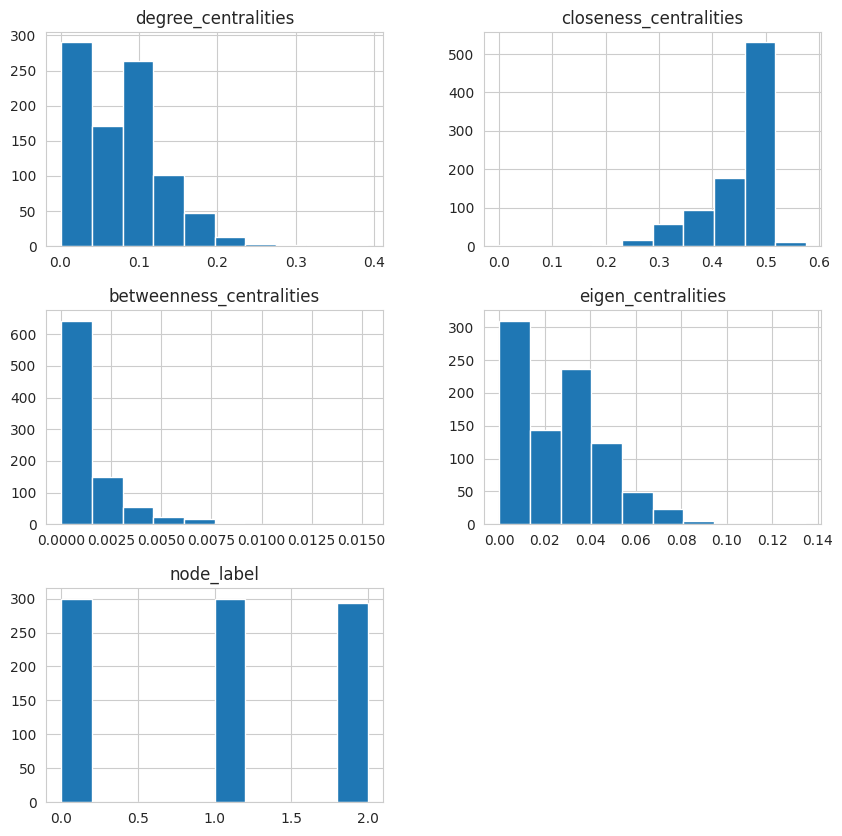

In [61]:
centralities_df.hist(bins=10, figsize=(10, 10))

In [70]:
N = 3
for col in centralities_df.columns:
    print(f"Top {N} max values in column {col}:")
    top_n_nodes_indices = centralities_df[col].nlargest(N).index.to_list()
    print(centralities_df.loc[top_n_nodes_indices, [col, "node_label"]])
    print()

Top 3 max values in column degree_centralities:
     degree_centralities  node_label
109             0.391499           0
282             0.364653           0
143             0.317673           0

Top 3 max values in column closeness_centralities:
     closeness_centralities  node_label
109                0.575035           0
282                0.564447           0
143                0.552177           0

Top 3 max values in column betweenness_centralities:
     betweenness_centralities  node_label
109                  0.015308           0
211                  0.015028           0
333                  0.012908           1

Top 3 max values in column eigen_centralities:
     eigen_centralities  node_label
109            0.134796           0
282            0.124114           0
143            0.106720           0

Top 3 max values in column node_label:
     node_label  node_label
600           2           2
601           2           2
602           2           2



In [76]:
centralities_df.loc[109]

degree_centralities         0.391499
closeness_centralities      0.575035
betweenness_centralities    0.015308
eigen_centralities          0.134796
node_label                  0.000000
Name: 109, dtype: float64